# Simulation d'un Écoulement Incompressible autour d'une Sphère (Obstacle) en 2D

Dans ce notebook, nous proposons une approche par réseaux de neurones informés par la physique (PINN) pour résoudre un problème d'écoulement incompressible (Navier–Stokes stationnaire) autour d'un obstacle circulaire (que nous appellerons "sphère" bien qu'il s'agisse d'un cercle en 2D) placé au centre du domaine $[0,1]\times[0,1]$. 

## Principales Caractéristiques

1. **Obstacle au centre** : Le cercle de rayon 0.15 est centré en $(0.5,0.5)$. Aucun fluide ne circule à l'intérieur de cet obstacle.
2. **Équations de Navier–Stokes stationnaires** : 
   - Continuité : $\nabla \cdot \mathbf{u} = 0$
   - Équation de quantité de mouvement : $\rho(\mathbf{u}\cdot\nabla)\mathbf{u} = -\nabla p + \mu\nabla^2\mathbf{u}$ ici, nous considérons $\rho=1$ et une viscosité cinématique $\nu$.
3. **Conditions aux limites** :
   - **Entrée (x=0)** : vitesse imposée $u=1$, $v=0$.
   - **Sortie (x=1)** : pression nulle $p=0$ et condition de dérivée nulle pour la vitesse (façon simplifiée de modéliser une sortie libre).
   - **Parois horizontales (y=0 et y=1)** : vitesse nulle (paroi fixe, no-slip).
   - **Sphère** : condition no-slip sur la frontière ($u=0$, $v=0$). Aucune équation de fluide à l'intérieur du cercle.
4. **Viscosité** : Nous choisissons \(\nu=0.005\) pour rendre le phénomène plus visible.
5. **Visualisation** : Nous superposons un dessin du cercle (obstacle) sur les champs de vitesse et de pression pour montrer clairement la zone dans laquelle le fluide n'est pas défini.

Cette implémentation vise à corriger le fait qu'aucune grandeur (pression, vitesse) ne doit être définie à l'intérieur de la sphère, et à représenter plus clairement la zone de l'obstacle dans les visualisations.

In [1]:
import torch
from torch.autograd import grad, Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cpu


## Géométrie et Obstacles

Le domaine de calcul est \([0,1]\times[0,1]\). L'obstacle est un cercle de rayon \(r=0.15\) centré en \((0.5, 0.5)\). Nous imposons qu'aucune équation de fluide ne soit résolue à l'intérieur de cet obstacle, et nous appliquons la condition de vitesse nulle (no-slip) sur son contour.

In [2]:
def plot_velocity_pressure(net, nx=80, ny=80, radius=0.15):
    """
    Visualise le champ de vitesse (u, v) et le champ de pression p sur une grille régulière
    dans le domaine [0,1] x [0,1]. Ajoute un cercle pour représenter l'obstacle.
    """
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)

    x_flat = X.reshape(-1, 1)
    y_flat = Y.reshape(-1, 1)

    # Conversion en tenseurs
    pt_x = Variable(torch.from_numpy(x_flat).float(), requires_grad=False).to(device)
    pt_y = Variable(torch.from_numpy(y_flat).float(), requires_grad=False).to(device)

    # Prédiction du réseau : (u, v, p)
    output = net(pt_x, pt_y)
    u = output[:, 0].view(X.shape).detach().cpu().numpy()
    v = output[:, 1].view(X.shape).detach().cpu().numpy()
    p = output[:, 2].view(X.shape).detach().cpu().numpy()

    # Masquage : on exclut (u,v,p) à l'intérieur de la sphère
    r2 = (X - 0.5)**2 + (Y - 0.5)**2
    inside_mask = r2 < radius**2
    # Mettre à NaN tout ce qui est à l'intérieur de la sphère
    u[inside_mask] = np.nan
    v[inside_mask] = np.nan
    p[inside_mask] = np.nan

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)

    # Champ de vitesse
    # On peut sous-échantillonner pour un affichage plus clair
    skip = 3
    ax.quiver(X[::skip, ::skip], Y[::skip, ::skip], u[::skip, ::skip], v[::skip, ::skip], color='b')
    ax.set_title("Champ de Vitesse (u, v)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Dessin de la sphère (obstacle)
    circle = plt.Circle((0.5, 0.5), radius, color='black', fill=False, linewidth=2)
    ax.add_patch(circle)

    plt.show()

    # Champ de pression
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    cp = ax.contourf(X, Y, p, levels=50, cmap='jet')
    ax.set_title("Champ de Pression")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(cp)

    # Dessin de la sphère (obstacle) sur la carte de pression
    circle2 = plt.Circle((0.5, 0.5), radius, color='black', fill=False, linewidth=2)
    ax.add_patch(circle2)

    plt.show()


## Formulation du Problème Physique

Nous considérons les équations de Navier–Stokes stationnaires pour un fluide incompressible (densité \(\rho=1\)) :

- **Continuité** : \(
abla \cdot \mathbf{u} = 0\),
- **Quantité de mouvement** :
  \(
  (\mathbf{u}\cdot\nabla)\mathbf{u} = -\nabla p + \nu \nabla^2 \mathbf{u}.
  \)

où \(\mathbf{u} = (u,v)\) est le champ de vitesse, \(p\) la pression, et \(\nu\) la viscosité cinématique (ici fixée à 0.005).

### Conditions aux Limites

1. **Entrée (x=0)** : \(u=1\) et \(v=0\) (injection horizontale).
2. **Sortie (x=1)** : \(p=0\) (façon simplifiée de modéliser une sortie libre) et \(\partial u/\partial x = 0\), \(\partial v/\partial x = 0\).
3. **Parois horizontales (y=0 et y=1)** : no-slip => \(u=0, v=0\).
4. **Sphère (rayon=0.15, centre=(0.5,0.5))** : no-slip => \(u=0, v=0\) sur la frontière. Aucun fluide à l'intérieur (pas de calcul).

In [3]:
class forward_problem:
    def __init__(self, net=None, nu=0.005):
        """
        Initialise le problème avec :
          - net : le réseau de neurones (u, v, p)
          - nu : la viscosité cinématique
        """
        self.net = net
        self.nu = nu
        
    def pde_residual(self, x, y):
        """
        Calcule les résidus de :
          - Continuité : du/dx + dv/dy = 0
          - Quantité de mouvement en x : u du/dx + v du/dy = -dp/dx + nu * (u_xx + u_yy)
          - Quantité de mouvement en y : u dv/dx + v dv/dy = -dp/dy + nu * (v_xx + v_yy)
        """
        out = self.net(x, y)
        u = out[:, 0:1]
        v = out[:, 1:2]
        p = out[:, 2:3]

        # Dérivées premières
        u_x = grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y = grad(u, y, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_x = grad(v, x, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_y = grad(v, y, torch.ones_like(v), retain_graph=True, create_graph=True)[0]

        continuity = u_x + v_y

        # Dérivées secondes
        u_xx = grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_yy = grad(u_y, y, torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]
        v_xx = grad(v_x, x, torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]
        v_yy = grad(v_y, y, torch.ones_like(v_y), retain_graph=True, create_graph=True)[0]

        # Pression
        p_x = grad(p, x, torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        p_y = grad(p, y, torch.ones_like(p), retain_graph=True, create_graph=True)[0]

        momentum_x = (u * u_x + v * u_y) + p_x - self.nu * (u_xx + u_yy)
        momentum_y = (u * v_x + v * v_y) + p_y - self.nu * (v_xx + v_yy)

        return continuity, momentum_x, momentum_y

    def bc_inlet(self, x, y):
        """
        Condition sur la frontière x=0 : (u=1, v=0).
        """
        out = self.net(x, y)
        u_pred = out[:, 0:1]
        v_pred = out[:, 1:2]
        u_target = torch.ones_like(u_pred)
        v_target = torch.zeros_like(v_pred)
        return (u_pred - u_target), (v_pred - v_target)

    def bc_outlet(self, x, y):
        """
        Sortie x=1 : p=0.
        On peut imposer p=0, et dérivée nulle de u,v par rapport à x (approx. outflow).
        """
        out = self.net(x, y)
        p_pred = out[:, 2:3]
        # Optionnel : du/dx, dv/dx ~ 0, on peut l'ajouter si on veut un outflow plus réaliste.
        return p_pred

    def bc_top_bottom(self, x, y):
        """
        Parois horizontales y=0 et y=1 : no-slip => u=0, v=0.
        """
        out = self.net(x, y)
        u_pred = out[:, 0:1]
        v_pred = out[:, 1:2]
        return u_pred, v_pred

    def bc_sphere(self, x, y):
        """
        Condition no-slip sur la sphère : u=0, v=0.
        """
        out = self.net(x, y)
        u_pred = out[:, 0:1]
        v_pred = out[:, 1:2]
        return u_pred, v_pred


## Réseau de Neurones (FCN)

Nous définissons un réseau feed-forward (Fully Connected Network) qui prend en entrée \((x, y)\) et renvoie \((u, v, p)\).

In [4]:
class FCN(torch.nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.hidden1 = torch.nn.Linear(2, 128)
        self.hidden2 = torch.nn.Linear(128, 128)
        self.hidden3 = torch.nn.Linear(128, 64)
        self.out = torch.nn.Linear(64, 3)  # (u, v, p)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        h = torch.tanh(self.hidden1(inputs))
        h = torch.tanh(self.hidden2(h))
        h = torch.tanh(self.hidden3(h))
        out = self.out(h)
        return out

## Mise en Place de la Boucle d'Entraînement

1. **Points de Collocation Extérieurs à la Sphère** : nous échantillonnons des points \((x,y)\) dans \([0,1]\times[0,1]\), puis nous filtrons ceux qui se trouvent à l'extérieur de la sphère (afin de n'appliquer la PDE que dans le fluide).
2. **Conditions aux Limites** :
   - **Inlet (x=0)** : \(u=1, v=0\)
   - **Outlet (x=1)** : \(p=0\)
   - **Top/Bottom (y=0, y=1)** : \(u=0, v=0\)
   - **Sphère** : \(u=0, v=0\)

3. **Fonction de Perte** :
   \(
   \text{loss} = \text{loss\_pde} + \text{loss\_bc\_inlet} + \text{loss\_bc\_outlet} + \text{loss\_bc\_topbottom} + \text{loss\_bc\_sphere}.
   \)

Nous ajustons \(\nu\) à 0.005 pour améliorer la représentation du sillage (wake) derrière la sphère. 


In [7]:
def solve(problem, N_iter=5000, radius=0.15):
    """
    Procède à l'entraînement du PINN :
      - On échantillonne des points extérieurs à la sphère pour la PDE.
      - On impose les conditions aux limites : inlet, outlet, top/bottom, sphère.
    """
    net = problem.net
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    mse_loss = torch.nn.MSELoss()

    for epoch in range(N_iter):
        optimizer.zero_grad()

        #############################################
        # 1) ÉCHANTILLONNAGE POUR LA PDE (ext. sphère)
        #############################################
        N_interior = 2000
        x_int = torch.rand(N_interior, 1).to(device)
        y_int = torch.rand(N_interior, 1).to(device)

        # Filtrer les points à l'intérieur de la sphère
        r2 = (x_int - 0.5)**2 + (y_int - 0.5)**2
        mask_outside = (r2 > radius**2)
        x_outside = x_int[mask_outside].view(-1, 1)  # Ensuring 2D shape
        y_outside = y_int[mask_outside].view(-1, 1)

        x_outside = Variable(x_outside, requires_grad=True)
        y_outside = Variable(y_outside, requires_grad=True)

        cont, mx, my = problem.pde_residual(x_outside, y_outside)
        loss_pde = mse_loss(cont, torch.zeros_like(cont)) + \
                   mse_loss(mx, torch.zeros_like(mx)) + \
                   mse_loss(my, torch.zeros_like(my))

        #############################################
        # 2) CONDITIONS AUX LIMITES : INLET (x=0)
        #############################################
        N_inlet = 200
        y_inlet = torch.rand(N_inlet, 1).to(device)
        x_inlet = torch.zeros_like(y_inlet)
        bc_in_u, bc_in_v = problem.bc_inlet(x_inlet, y_inlet)
        loss_bc_inlet = mse_loss(bc_in_u, torch.zeros_like(bc_in_u)) + \
                        mse_loss(bc_in_v, torch.zeros_like(bc_in_v))

        #############################################
        # 3) OUTLET (x=1) : p=0
        #############################################
        N_outlet = 200
        y_outlet = torch.rand(N_outlet, 1).to(device)
        x_outlet = torch.ones_like(y_outlet)
        bc_out_p = problem.bc_outlet(x_outlet, y_outlet)
        loss_bc_outlet = mse_loss(bc_out_p, torch.zeros_like(bc_out_p))

        #############################################
        # 4) TOP / BOTTOM (y=0 et y=1) : u=0, v=0
        #############################################
        N_tb = 200
        x_tb = torch.rand(N_tb, 1).to(device)

        # y=0
        y_bot = torch.zeros_like(x_tb)
        bc_bot_u, bc_bot_v = problem.bc_top_bottom(x_tb, y_bot)
        loss_bc_bot = mse_loss(bc_bot_u, torch.zeros_like(bc_bot_u)) + \
                       mse_loss(bc_bot_v, torch.zeros_like(bc_bot_v))

        # y=1
        y_top = torch.ones_like(x_tb)
        bc_top_u, bc_top_v = problem.bc_top_bottom(x_tb, y_top)
        loss_bc_top = mse_loss(bc_top_u, torch.zeros_like(bc_top_u)) + \
                      mse_loss(bc_top_v, torch.zeros_like(bc_top_v))

        loss_bc_tb = loss_bc_bot + loss_bc_top

        #############################################
        # 5) BORD DE LA SPHÈRE : NO-SLIP
        #############################################
        N_sphere = 200
        theta = 2.0 * np.pi * torch.rand(N_sphere, 1).to(device)
        x_sph = 0.5 + radius * torch.cos(theta)
        y_sph = 0.5 + radius * torch.sin(theta)
        bc_sph_u, bc_sph_v = problem.bc_sphere(x_sph, y_sph)
        loss_bc_sphere = mse_loss(bc_sph_u, torch.zeros_like(bc_sph_u)) + \
                         mse_loss(bc_sph_v, torch.zeros_like(bc_sph_v))

        #############################################
        # 6) LOSS TOTALE
        #############################################
        loss = loss_pde + loss_bc_inlet + loss_bc_outlet + loss_bc_tb + loss_bc_sphere

        loss.backward()
        optimizer.step()

        # Affichage périodique
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            plot_velocity_pressure(net, radius=radius)


## Instanciation et Lancement de la Simulation

Nous créons l'objet `FCN` (réseau de neurones), puis le `forward_problem` qui décrit la physique. Enfin, nous appelons la fonction `solve` pour entraîner le modèle. Les visualisations (vitesse et pression) sont affichées toutes les 500 itérations, avec le cercle représentant l'obstacle superposé.

<IPython.core.display.Javascript object>

Epoch 0, Loss: 1.152615


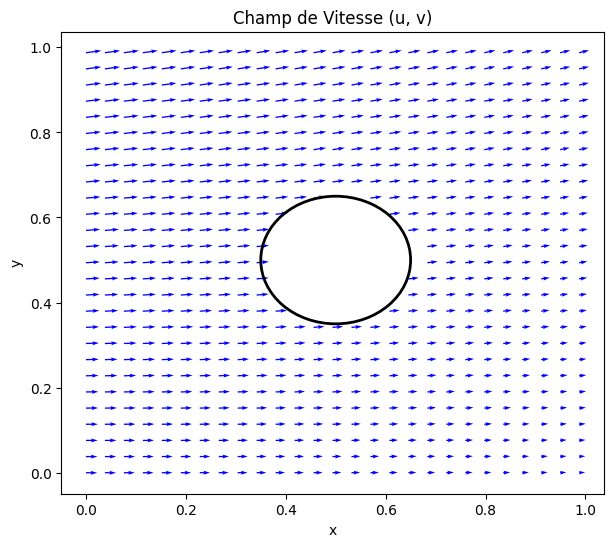

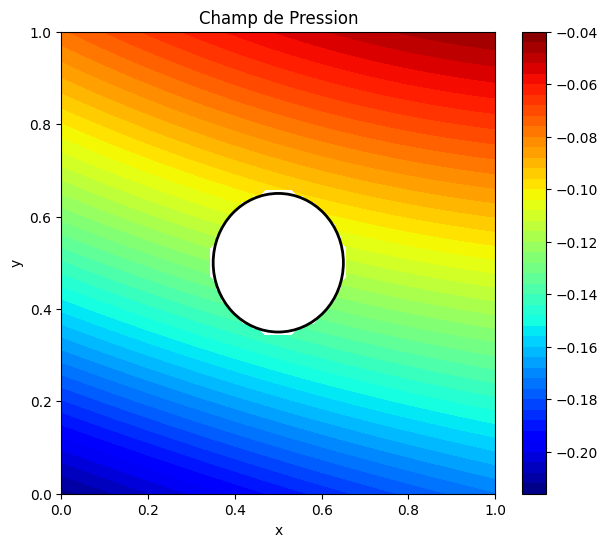

Epoch 500, Loss: 0.399737


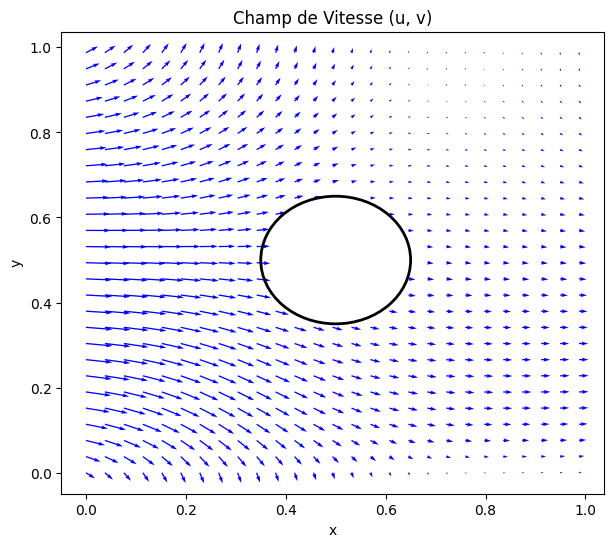

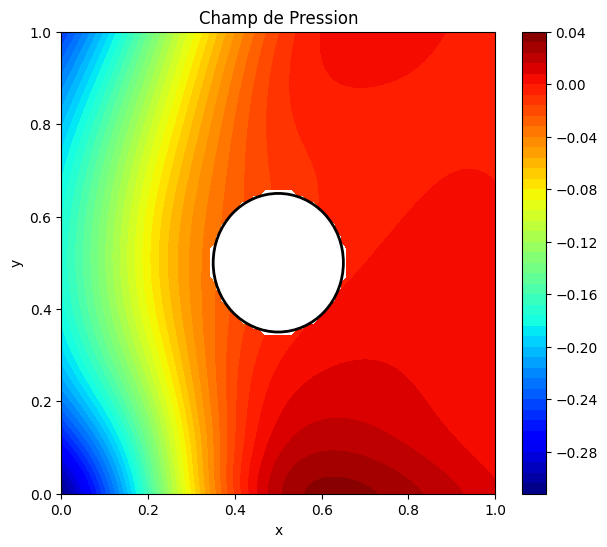

Epoch 1000, Loss: 0.259327


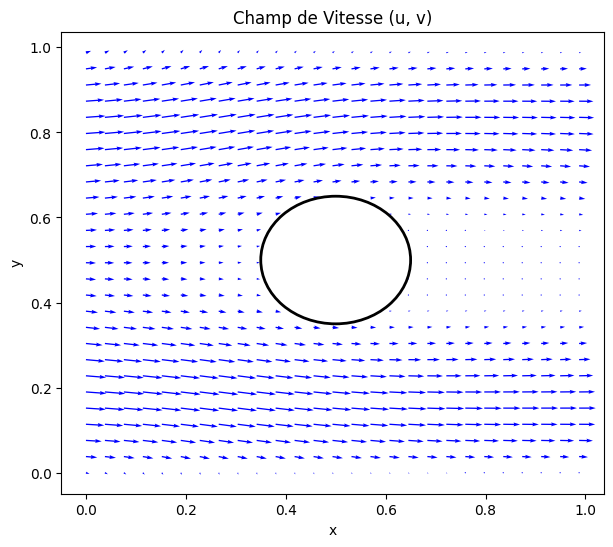

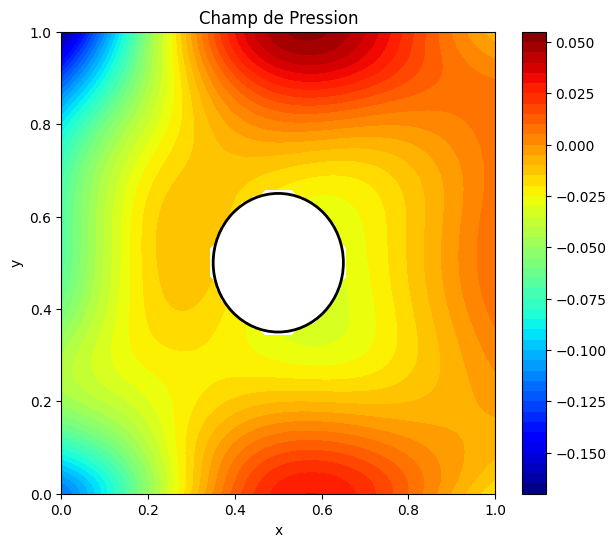

Epoch 1500, Loss: 0.223749


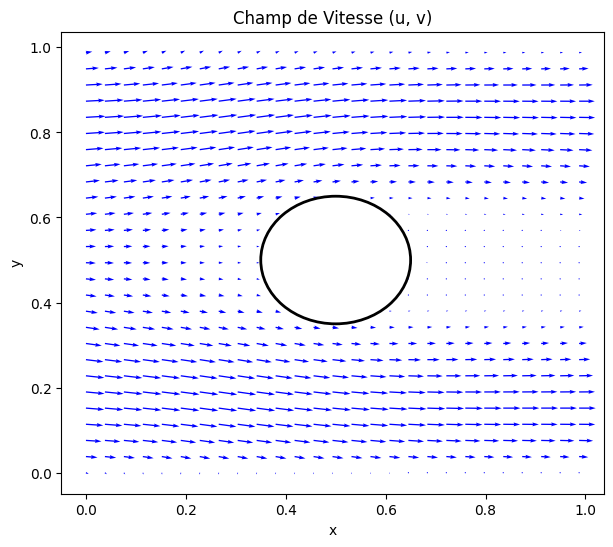

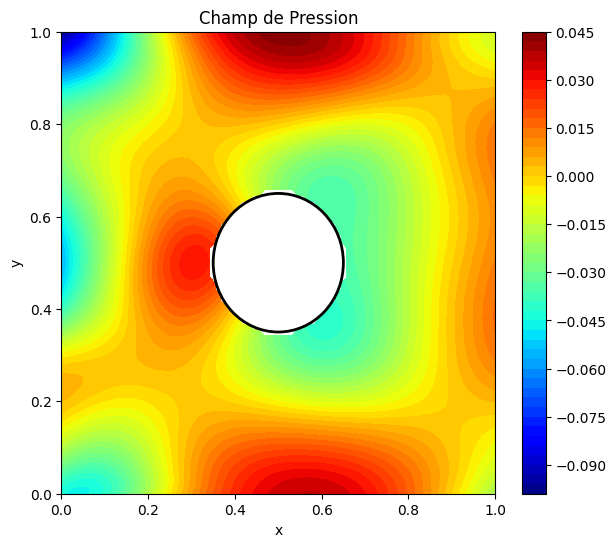

Epoch 2000, Loss: 0.217879


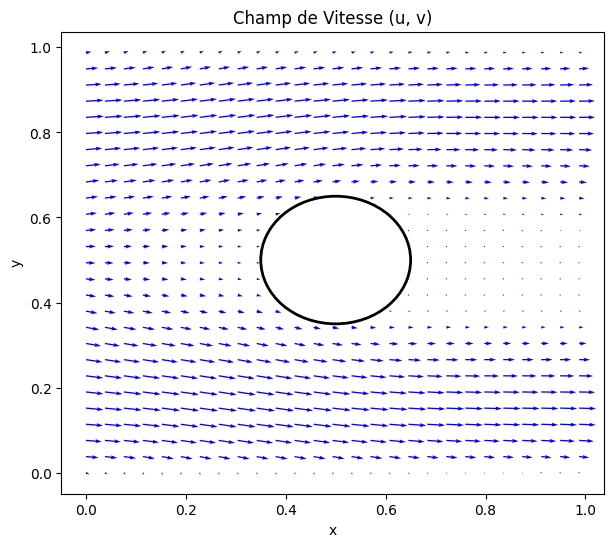

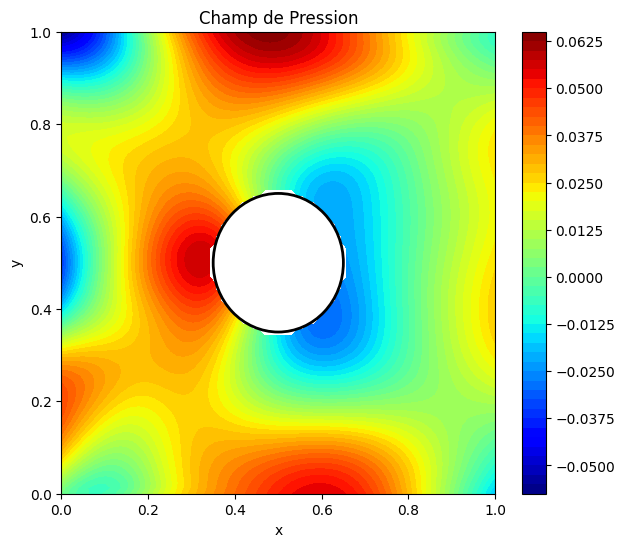

Epoch 2500, Loss: 0.208605


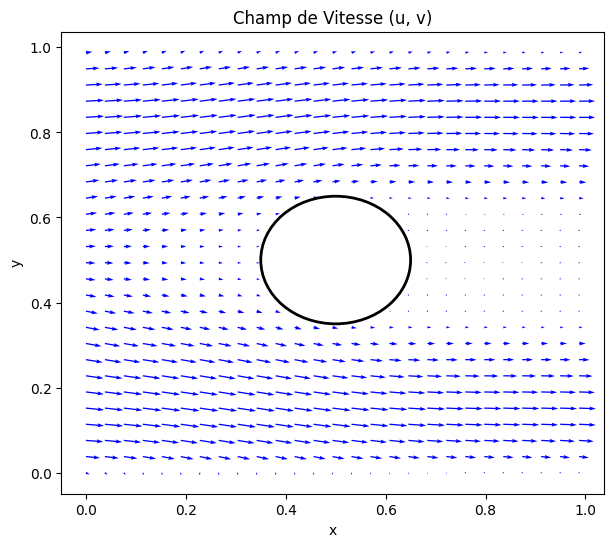

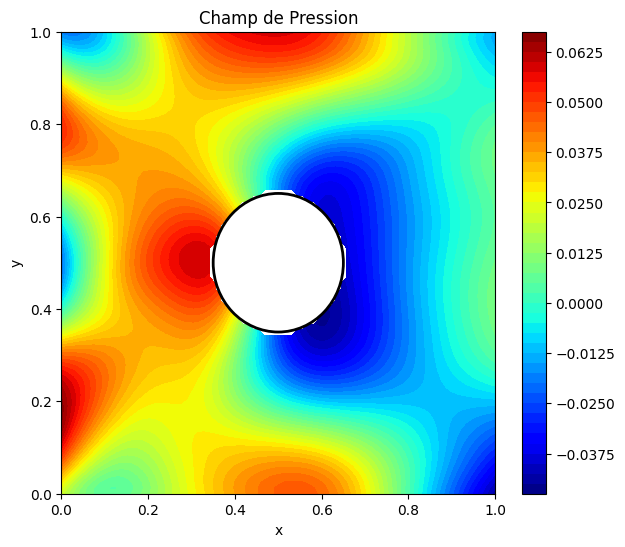

In [8]:
net = FCN().to(device)
fluid_problem = forward_problem(net, nu=0.005)

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

# Lancement de l'entraînement
solve(fluid_problem, N_iter=3000, radius=0.15)

## Conclusion et Perspectives

1. **Prise en compte de l'Obstacle** : Grâce à l'échantillonnage excluant la sphère, ainsi qu'à l'imposition de no-slip sur sa frontière, la vitesse et la pression ne sont pas définies à l'intérieur de la sphère. Les champs \((u,v,p)\) s'annulent donc sur le bord et restent inexistants (ou masqués) dans la zone solide.
2. **Viscosité Réduite** : Le choix de \(\nu=0.005\) permet d'observer plus nettement le sillage et la variation de pression autour de l'obstacle. Une viscosité trop élevée aurait tendance à lisser davantage l'écoulement.
3. **Visualisation** : Les figures montrent le champ de vitesse et le champ de pression dans la zone fluide. Nous superposons le cercle pour illustrer clairement l'emplacement de la sphère.

### Améliorations Potentielles
- **Pondération Dynamique des Termes** : Ajuster les coefficients dans la loss pour équilibrer la PDE et les BC.
- **Cas Transitoire (Non Stationnaire)** : Ajouter un terme \(\partial_t \mathbf{u}\) pour capturer la dynamique temporelle.
- **Extension 3D** : Même principe, mais le domaine et l'obstacle deviennent un volume.
- **Approche Hybride** : Intégration de mesures expérimentales ou issues de simulations traditionnelles (CFD) pour guider l'entraînement.

Cette démarche constitue une étape supplémentaire vers la modélisation précise d'écoulements complexes à l'aide des PINNs, en veillant à exclure correctement les zones solides du domaine de calcul.